# Técnicas de aprendizaje no supervisado y espectroscopía Raman para descubrir patrones de pigmentación en conchas arqueológicas de moluscos

Trabajo de Fin de Máster para acceder al **Máster en Ciencia de Datos**

Autor: Andrea Pérez Asensio

Director: Adolfo Cobo García

Co-Director: David Cuenca Solana

El objetivo principal de este trabajo es el de analizar espectros Raman de conchas de moluscos para poder estudiar la coloración de las muestras y predecir el color que tuvieron unas conchas arqueológicas que han perdido el color.

En este *Notebook* se recoge todo el código utilizado en el análisis de los espectros Raman.

# 1. Carga de paquetes y de datos
Se realiza la importación de los paquetes utilizados y se cargan los datos. Se realiza un preprocesado que consiste en la etiquetación y concatenación de los datos, obteniendo un *DataFrame* de *pandas* con un multi-índice

In [1]:
import numpy as np
import pandas as pd
#%matplotlib inline
import re
import os
import math
import numpy as np
import pandas as pd
import joblib
import warnings
import time
import matplotlib.pyplot as plt

# Importamos nuestras funciones
import sys
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, Birch
from sklearn.decomposition import PCA

print("Todos los paquetes necesarios han sido importados")


Todos los paquetes necesarios han sido importados


## 1.1. Carga de los datos.

Se cargan los datos obtenidos tanto por la Sonda de 532nm como los medidos utilizando el micoscópio Nanobase.
Los CSV que se cargan contienen los espectros preprocesados de las diferentes conchas. Para más información sobre el preprocesado elegido consulte **procesado_nanobase.ipynb** y **procesado_sonda532nm.ipynb**

In [5]:
# Cargamos todos los datasets 
data_sonda_2023_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2023_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])
data_sonda_2024_Matlab = pd.read_csv('D:\OneDrive - UNICAN\Escritorio\Conchas\CSV_final\data_sonda_2024_preprocesadoMatlab.csv', index_col=[0,1,2,3,4,5,6,7])

In [6]:
data_sonda_Matlab = pd.concat([data_sonda_2023_Matlab, data_sonda_2024_Matlab])

In [7]:
data_sonda_Matlab

178.6  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                
Sonda 523nm LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023...  0.039 -0.398  441.31   
                                                                                                 0.089 -0.398  307.40   
                                                                                                 0.139 -0.398  322.41   
                                                                                                 0.189 -0.398  299.98   
                                                                                                 0.239 -0.398  332.57   
...                                                                                                               ...   
Sonda 532nm LIT921.1 preproc 30042024 103017 30042024-103017_conchas_532nm_LIT921.1_n10_500m... -1.336  4.090     NaN   
                                                                                                -1.296  4.090     NaN   
                                                                                                -1.256  4.090     NaN   
                                                                                                -1.216  4.090     NaN   
                                                                                                -1.176  4.090     NaN   

                                                                                                               182.29  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                
Sonda 523nm LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023...  0.039 -0.398  484.68   
                                                                                                 0.089 -0.398  362.50   
                                                                                                 0.139 -0.398  338.21   
                                                                                                 0.189 -0.398  339.76   
                                                                                                 0.239 -0.398  295.95   
...                                                                                                               ...   
Sonda 532nm LIT921.1 preproc 30042024 103017 30042024-103017_conchas_532nm_LIT921.1_n10_500m... -1.336  4.090     NaN   
                                                                                                -1.296  4.090     NaN   
                                                                                                -1.256  4.090     NaN   
                                                                                                -1.216  4.090     NaN   
                                                                                                -1.176  4.090     NaN   

                                                                                                               185.98  \
Instrumento Muestra  Tipo    Fecha    Hora   Archivo                                            X      Y                
Sonda 523nm LIT235.3 preproc 11042023 154845 arq235_exported_csv_singlefile_preproc_11042023...  0.039 -0.398  308.03   
                                                                                                 0.089 -0.398  302.82   
                                                                                                 0.139 -0.398  256.89   
                                                                                                 0.189 -0.398  277.52   
                                                                                                 0.239 -0.398  257.22   
...                                                                                                               ...

# 2. Reducción de la dimensionalidad

In [7]:
data_2023_moderna = data_sonda_2023[~data_sonda_2023.index.get_level_values('Muestra').isin(['LIT235.3', 'LIT885.1'])].dropna()
data_2023_arq = data_sonda_2023[data_sonda_2023.index.get_level_values('Muestra').isin(['LIT235.3', 'LIT885.1'])]

# 3. Clusterización


Para la elección del número de clusters utilizamos el método del codo

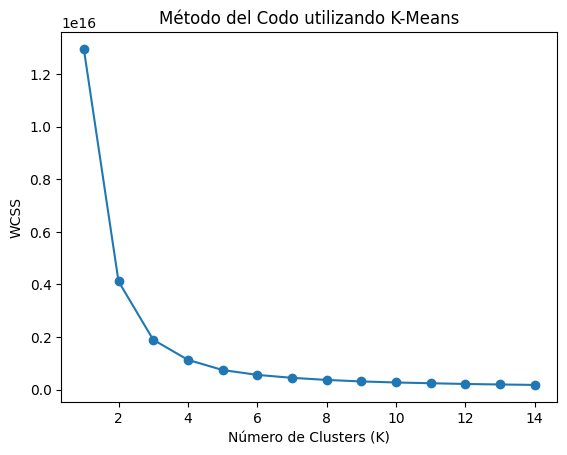

Se ha terminado el proceso en 120.5 s


In [5]:
from scipy.cluster.hierarchy import linkage
def elbow_method (data, k_values, metodo_clustering, nombre_archivo="No"):
     wcss = [] # Suma de los cuadrados de la distancia
     if metodo_clustering == 'K-Means':
           for k in k_values:
                model = KMeans(n_clusters=k)
                model.fit(data)
                wcss.append(model.inertia_)
                # La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide 
                # de su cluster asignado y sumando estos 
                # valores para todos los clusters. 
                # Esencialmente, mide la dispersión dentro de cada cluster.
     elif metodo_clustering == 'Agglomerative':
           for k in k_values:
                model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
                labels = model.fit_predict(data)
                linkage_matrix = linkage(data, method='ward')
                wcss.append(sum([d**2 for d in linkage_matrix[:, 2]]))
                #La WCSS se calcula sumando la distancia al cuadrado de cada punto al centroide
                #  del cluster final al que pertenece. La matriz de enlace se utiliza para
                #  determinar a qué cluster final se asigna cada punto.
     else:
        raise ValueError("Método de clustering no válido. Use 'K-Means' o 'Agglomerative'.")
        return
     
     #En resumen, tanto K-Means como Aglomerativo buscan minimizar la dispersión dentro 
     # de los clusters, pero utilizan enfoques diferentes para lograrlo. 
     # K-Means ajusta centroides iterativamente, mientras que Aglomerativo fusiona clusters 
     # jerárquicamente. El cálculo específico de WCSS refleja cómo se mide la dispersión 
     # dentro de los clusters para cada método.

    # Graficar el método del codo
     plt.plot(k_values, wcss, marker='o')
     plt.xlabel('Número de Clusters (K)')
     plt.ylabel('WCSS')
     plt.title(f'Método del Codo utilizando {metodo_clustering}')
     if nombre_archivo != "No":
      plt.savefig(f'Graficas/MetodoCodo/{nombre_archivo}_{metodo_clustering}.png')
     plt.show()

warnings.filterwarnings("ignore")
# Medimos el tiempo
t1 = time.time()

elbow_method(data_2023_moderna, range(1,10),"K-Means")
t2 = time.time()
print(f"Se ha terminado el proceso en {round(t2-t1,2)} s")

In [9]:
warnings.filterwarnings('ignore')

t1 = time.time()

kmeans = KMeans(n_clusters=5, random_state=100).fit(data_2023_moderna)
centroies_values = kmeans.cluster_centers_
data_2023_moderna['KMeans'] = kmeans.labels_
data_2023_moderna = data_2023_moderna.set_index('KMeans', append=True)

t2 = time.time()    
print('Tiempo de ejecución: ', t2-t1)

data_2023_moderna

Tiempo de ejecución:  5.0918049812316895


178.6  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y      KMeans            
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243 0       26053.0   
                                                                                               58.231 19.243 4       27731.0   
                                                                                               58.281 19.243 4       27219.0   
                                                                                               58.331 19.243 0       26968.0   
                                                                                               58.381 19.243 0       26498.0   
...                                                                                                                      ...   
            LIT5    preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617 24.102 3        8586.6   
                                                                                               95.667 24.102 3        8480.9   
                                                                                               95.717 24.102 3        8355.6   
                                                                                               95.767 24.102 3        8392.8   
                                                                                               95.817 24.102 3        8824.6   

                                                                                                                      182.29  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y      KMeans            
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243 0       26233.0   
                                                                                               58.231 19.243 4       28055.0   
                                                                                               58.281 19.243 4       27495.0   
                                                                                               58.331 19.243 0       27187.0   
                                                                                               58.381 19.243 0       26742.0   
...                                                                                                                      ...   
            LIT5    preproc 21032023 153433 moderna5_exported_csv_singlefile_raw_21032023-1... 95.617 24.102 3        8660.8   
                                                                                               95.667 24.102 3        8507.1   
                                                                                               95.717 24.102 3        8428.9   
                                                                                               95.767 24.102 3        8461.6   
                                                                                               95.817 24.102 3        8874.7   

                                                                                                                      185.98  \
Instrumento Muestra Tipo    Fecha    Hora   Archivo                                            X      Y      KMeans            
Sonda 2023  LIT1    preproc 19032023 125521 moderna1_exported_csv_singlefile_raw_19032023-1... 58.181 19.243 0       26616.0   
                                                                                               58.231 19.243 4       28245.0   
                                                                                               58.281 19.243 4       27801.0   
                                                                                               58.331 19.243 0       27429.0   
                     